## Logit-Based KD

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Setting hyperparameters
batch_size, learning_rate, epochs = 64, 0.0005, 30
temperature, alpha = 5.0, 0.7


In [ ]:
# Data Transformations and Loaders
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(full_train_data))
train_data, val_data = random_split(full_train_data, [train_size, len(full_train_data) - train_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transform, download=True),
                         batch_size=batch_size, shuffle=False)


100%|██████████| 170M/170M [00:02<00:00, 79.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Teacher Model
class TeacherNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self._to_linear = self._get_flattened_size()
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 10)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.rand(1, 3, 32, 32)
            x = self.convs(x)
        return x.numel()

    def forward(self, x):
        x = self.convs(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
# Variable-Size Student Model
class StudentNet(nn.Module):
    def __init__(self, conv1_out_channels, conv2_out_channels, fc1_out_features):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, conv1_out_channels, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self._to_linear = self._get_flattened_size()
        self.fc1 = nn.Linear(self._to_linear, fc1_out_features)
        self.fc2 = nn.Linear(fc1_out_features, 10)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.rand(1, 3, 32, 32)
            x = self.convs(x)
        return x.numel()

    def forward(self, x):
        x = self.convs(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
# Distillation Loss Function
def distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha):
    soft_targets = F.kl_div(
        F.log_softmax(student_outputs / temperature, dim=1),
        F.softmax(teacher_outputs / temperature, dim=1),
        reduction="batchmean"
    ) * (temperature ** 2)
    hard_targets = F.cross_entropy(student_outputs, labels)
    return alpha * soft_targets + (1 - alpha) * hard_targets


# Training and Validation Functions
def train(model, loader, optimizer, criterion, teacher_model=None, temperature=None, alpha=None):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        if teacher_model:
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss = criterion(outputs, teacher_outputs, labels, temperature, alpha)
        else:
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            total_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


In [ ]:
# Evaluate function for test accuracy
def evaluate_test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            total += labels.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
    return correct / total

# Training and Evaluating Teacher Model
teacher = TeacherNet().cuda()
teacher_optimizer = optim.Adam(teacher.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_acc_teacher, val_acc_teacher, test_acc_teacher = [], [], []
print("Training Teacher Model...")
for epoch in range(epochs):
    train_loss, train_acc = train(teacher, train_loader, teacher_optimizer, criterion)
    val_loss, val_acc = validate(teacher, val_loader, criterion)
    test_acc = evaluate_test(teacher, test_loader)
    train_acc_teacher.append(train_acc)
    val_acc_teacher.append(val_acc)
    test_acc_teacher.append(test_acc)
    print(f"Epoch {epoch+1}/{epochs}, Teacher Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Save the trained teacher model
torch.save(teacher.state_dict(), "best_teacher_model.pth")

# Display final test accuracy
final_test_accuracy = test_acc_teacher[-1] * 100
print(f"Final Teacher Model Test Accuracy: {final_test_accuracy:.2f}%")


Training Teacher Model...
Epoch 1/30, Teacher Train Acc: 0.4261, Val Acc: 0.5281, Test Acc: 0.5269
Epoch 2/30, Teacher Train Acc: 0.5902, Val Acc: 0.6161, Test Acc: 0.6199
Epoch 3/30, Teacher Train Acc: 0.6535, Val Acc: 0.6651, Test Acc: 0.6675
Epoch 4/30, Teacher Train Acc: 0.6952, Val Acc: 0.6888, Test Acc: 0.6857
Epoch 5/30, Teacher Train Acc: 0.7208, Val Acc: 0.7209, Test Acc: 0.7156
Epoch 6/30, Teacher Train Acc: 0.7459, Val Acc: 0.7320, Test Acc: 0.7273
Epoch 7/30, Teacher Train Acc: 0.7598, Val Acc: 0.7438, Test Acc: 0.7414
Epoch 8/30, Teacher Train Acc: 0.7720, Val Acc: 0.7465, Test Acc: 0.7472
Epoch 9/30, Teacher Train Acc: 0.7842, Val Acc: 0.7658, Test Acc: 0.7642
Epoch 10/30, Teacher Train Acc: 0.7937, Val Acc: 0.7707, Test Acc: 0.7653
Epoch 11/30, Teacher Train Acc: 0.8027, Val Acc: 0.7772, Test Acc: 0.7690
Epoch 12/30, Teacher Train Acc: 0.8101, Val Acc: 0.7738, Test Acc: 0.7677
Epoch 13/30, Teacher Train Acc: 0.8184, Val Acc: 0.7817, Test Acc: 0.7760
Epoch 14/30, Teacher 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def plot_confusion_matrix(model, data_loader, class_names, title="Confusion Matrix"):
    model.eval()
    y_true = []
    y_pred = []

    # Gather true labels and predictions
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.yticks(rotation=0)   # Keep y-axis labels horizontal
    plt.tight_layout()
    plt.show()




Confusion Matrix for Teacher Model:


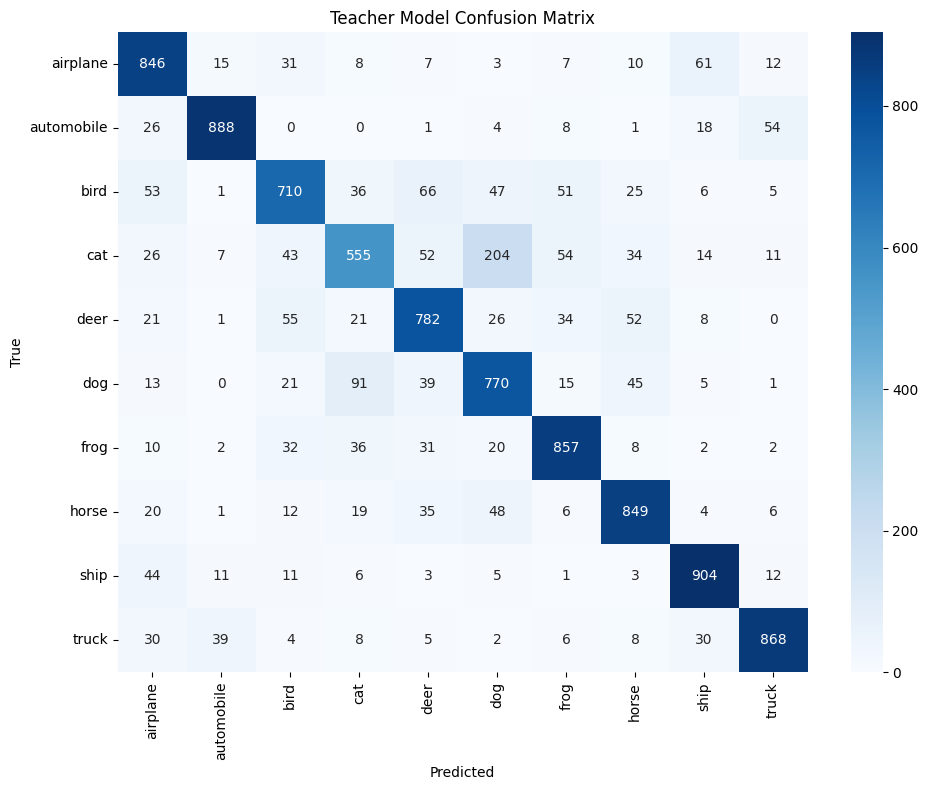

In [ ]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Generate confusion matrix for Teacher Model
print("Confusion Matrix for Teacher Model:")
plot_confusion_matrix(teacher, test_loader, class_names, title="Teacher Model Confusion Matrix")


In [ ]:
# Define the function to evaluate models on test data
def evaluate_model_on_test_data(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return  correct / total

# Load and evaluate the Teacher Model
teacher.load_state_dict(torch.load("best_teacher_model.pth"))
teacher.eval()
teacher_params = sum(p.numel() for p in teacher.parameters() if p.requires_grad)
teacher_accuracy = max(val_acc_teacher) * 100  # Max Teacher validation accuracy
teacher_test_accuracy = evaluate_model_on_test_data(teacher, test_loader)  # Evaluate Teacher on test data

# Print Teacher details
print(f"Teacher Model: {teacher_params:,} parameters")
print(f"Validation Accuracy: {teacher_accuracy:.2f}%")
print(f"Test Accuracy: {teacher_test_accuracy:.2f}%\n")

# Define student sizes
student_sizes = [
    (16, 32, 64),  # Small Student
    (32, 64, 128),  # Medium Student
    (48, 96, 256)  # Large Student
]

# Dictionary to store results for each Student model
student_results = {}

for conv1_out, conv2_out, fc1_out in student_sizes:
    print(f"\nTraining Student Model (Size: {conv1_out}x{conv2_out}x{fc1_out})")
    student = StudentNet(conv1_out, conv2_out, fc1_out).cuda()
    student_optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    # Track accuracy over epochs
    train_acc_student, val_acc_student, test_acc_student = [], [], []  # Added test accuracy tracking

    # Train the Student Model
    for epoch in range(epochs):
        train_loss, train_acc = train(student, train_loader, student_optimizer, distillation_loss, teacher, temperature, alpha)
        val_loss, val_acc = validate(student, val_loader, criterion)
        test_acc = evaluate_model_on_test_data(student, test_loader)  # Added test accuracy evaluation
        train_acc_student.append(train_acc)
        val_acc_student.append(val_acc)
        test_acc_student.append(test_acc)
        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")  # Print all accuracies

    # Save the trained Student Model
    torch.save(student.state_dict(), f"best_student_model_{conv1_out}_{conv2_out}_{fc1_out}.pth")

    # Calculate Student Model size, compression ratio
    student_params = sum(p.numel() for p in student.parameters() if p.requires_grad)
    compression_ratio = student_params / teacher_params
    student_accuracy = max(val_acc_student) * 100  # Max Student validation accuracy
    student_test_accuracy = max(test_acc_student) * 100  # Max Student test accuracy

    # Print Student details
    print(f"Student Model: {student_params:,} parameters")
    print(f"Compression Ratio (Student/Teacher): {compression_ratio:.4f}")
    print(f"Validation Accuracy: {student_accuracy:.2f}%")
    print(f"Test Accuracy: {student_test_accuracy:.2f}%\n")

    # Store the results
    student_results[f"Student_{conv1_out}x{conv2_out}x{fc1_out}"] = {
        "size": f"{conv1_out}x{conv2_out}x{fc1_out}",
        "params": student_params,
        "compression_ratio": compression_ratio,
        "train_acc": train_acc_student,
        "val_acc": val_acc_student,
        "test_acc": test_acc_student,  # Store epoch-wise test accuracies
        "accuracy": student_accuracy,
        "test_max_acc": student_test_accuracy,  # Max Test Accuracy
    }

print("Training and evaluation complete for all Student models.")


<ipython-input-15-14ee0a9fa4c1>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load("best_teacher_model.pth"))


Teacher Model: 33,930,890 parameters
Validation Accuracy: 81.73%
Test Accuracy: 0.80%


Training Student Model (Size: 16x32x64)
Epoch 1/30, Train Acc: 0.3505, Val Acc: 0.4193, Test Acc: 0.4222
Epoch 2/30, Train Acc: 0.4400, Val Acc: 0.4591, Test Acc: 0.4629
Epoch 3/30, Train Acc: 0.4730, Val Acc: 0.4832, Test Acc: 0.4841
Epoch 4/30, Train Acc: 0.4944, Val Acc: 0.5069, Test Acc: 0.5153
Epoch 5/30, Train Acc: 0.5140, Val Acc: 0.5119, Test Acc: 0.5160
Epoch 6/30, Train Acc: 0.5329, Val Acc: 0.5449, Test Acc: 0.5425
Epoch 7/30, Train Acc: 0.5540, Val Acc: 0.5672, Test Acc: 0.5624
Epoch 8/30, Train Acc: 0.5722, Val Acc: 0.5777, Test Acc: 0.5754
Epoch 9/30, Train Acc: 0.5832, Val Acc: 0.5812, Test Acc: 0.5824
Epoch 10/30, Train Acc: 0.6014, Val Acc: 0.6074, Test Acc: 0.6033
Epoch 11/30, Train Acc: 0.6085, Val Acc: 0.6066, Test Acc: 0.6058
Epoch 12/30, Train Acc: 0.6151, Val Acc: 0.6147, Test Acc: 0.6130
Epoch 13/30, Train Acc: 0.6209, Val Acc: 0.6227, Test Acc: 0.6244
Epoch 14/30, Train Acc:

Student Accuracy (48x96x256): 78.54%


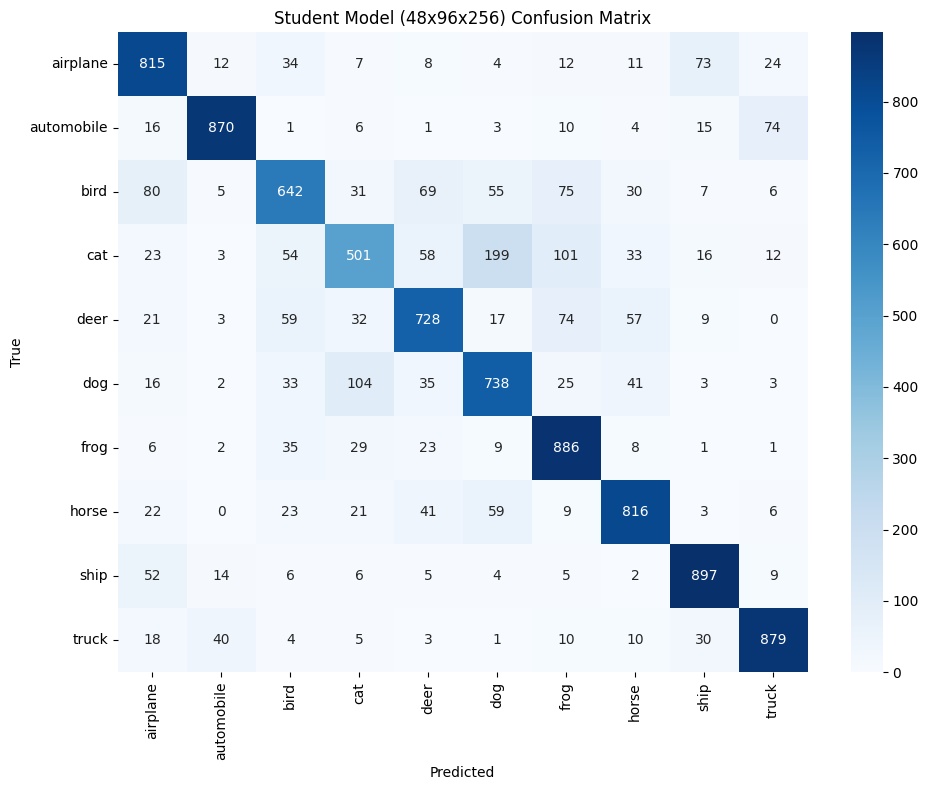

In [ ]:
# After each student model is trained
student_accuracy = max(val_acc_student) * 100
print(f"Student Accuracy ({conv1_out}x{conv2_out}x{fc1_out}): {student_accuracy:.2f}%")
plot_confusion_matrix(student, test_loader, class_names, title=f"Student Model ({conv1_out}x{conv2_out}x{fc1_out}) Confusion Matrix")


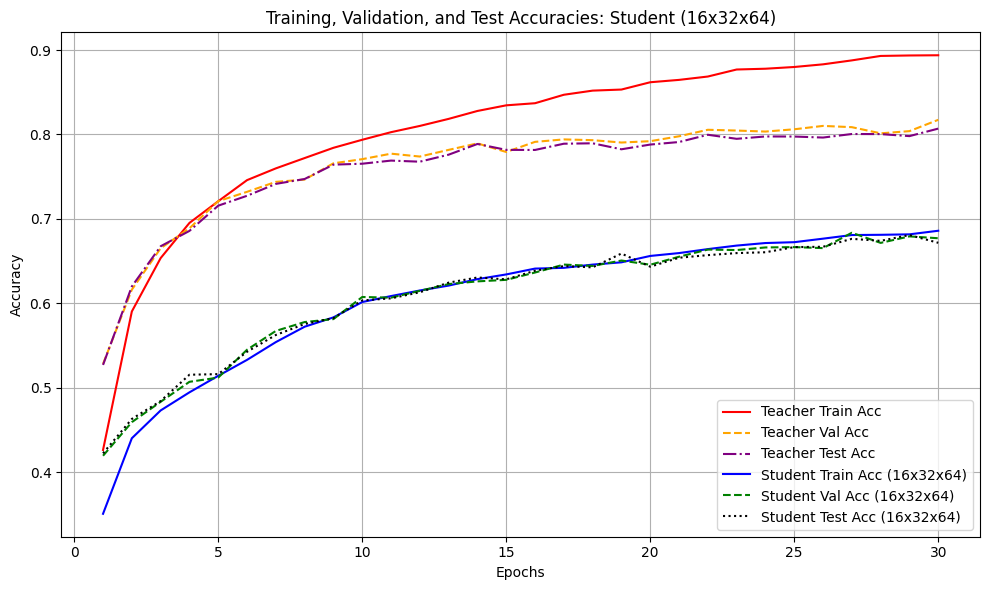

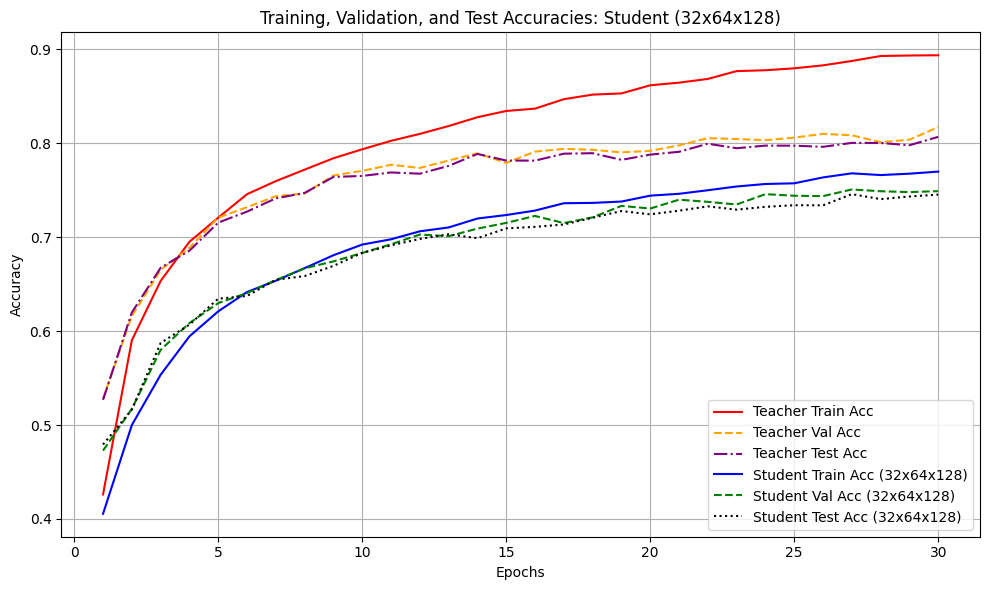

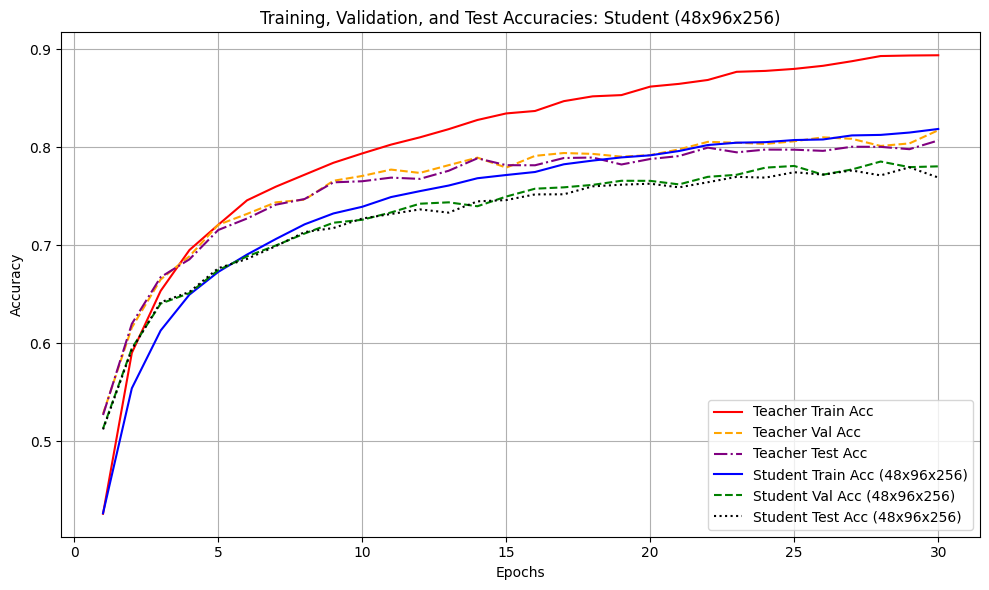

In [ ]:
# Plot Training, Validation, and Test Accuracies for Teacher and Students
for student_name, results in student_results.items():
    train_acc_student = results["train_acc"]
    val_acc_student = results["val_acc"]
    test_acc_student = results["test_acc"]  # List of test accuracies across epochs

    # Extract model size from student name
    model_size = student_name.split("_")[1:]  # E.g., ['16', '32', '64']

    # Plot Teacher and Student Accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_acc_teacher, label="Teacher Train Acc", color="red", linestyle="-")
    plt.plot(range(1, epochs + 1), val_acc_teacher, label="Teacher Val Acc", color="orange", linestyle="--")
    plt.plot(range(1, epochs + 1), test_acc_teacher, label="Teacher Test Acc", color="purple", linestyle="-.")

    plt.plot(range(1, epochs + 1), train_acc_student, label=f"Student Train Acc ({', '.join(model_size)})", color="blue", linestyle="-")
    plt.plot(range(1, epochs + 1), val_acc_student, label=f"Student Val Acc ({', '.join(model_size)})", color="green", linestyle="--")
    plt.plot(range(1, epochs + 1), test_acc_student, label=f"Student Test Acc ({', '.join(model_size)})", color="black", linestyle=":")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training, Validation, and Test Accuracies: Student ({', '.join(model_size)})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


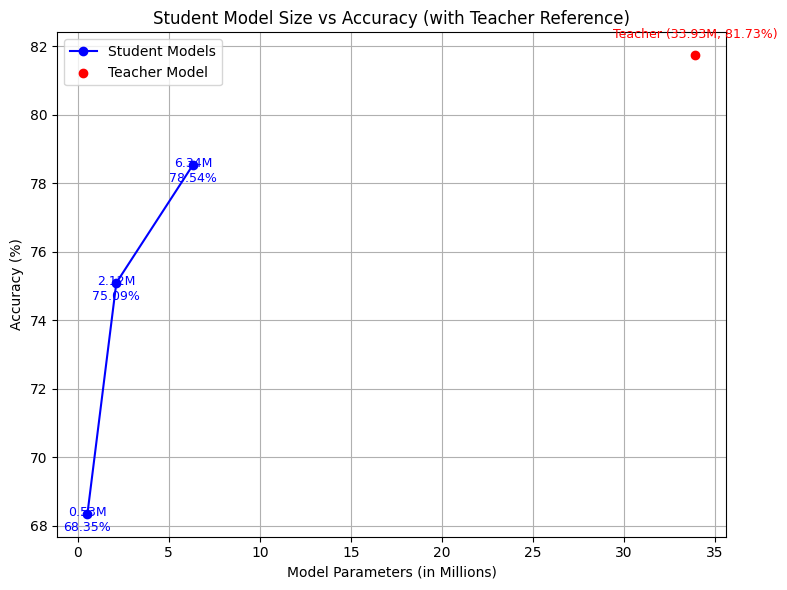

In [ ]:
# Collect Teacher and Student Metrics for Plotting
teacher_params = sum(p.numel() for p in teacher.parameters() if p.requires_grad)
teacher_accuracy = max(val_acc_teacher) * 100

student_parameters = [results["params"] for results in student_results.values()]
student_accuracies = [max(results["val_acc"]) * 100 for results in student_results.values()]

# Normalize Parameters for Better Visualization
teacher_params_normalized = teacher_params / 1e6
student_parameters_normalized = [params / 1e6 for params in student_parameters]

# Plot Model Size vs Accuracy
plt.figure(figsize=(8, 6))

# Plot Student Models
plt.plot(student_parameters_normalized, student_accuracies, marker='o', label="Student Models", color="blue")

# Annotate Student Models
for param, acc in zip(student_parameters_normalized, student_accuracies):
    plt.text(param, acc - 0.5, f"{param:.2f}M\n{acc:.2f}%", fontsize=9, ha="center", color="blue")

# Add Teacher Model Reference
plt.scatter([teacher_params_normalized], [teacher_accuracy], color='red', label="Teacher Model", zorder=5)
plt.text(teacher_params_normalized, teacher_accuracy + 0.5,
         f"Teacher ({teacher_params_normalized:.2f}M, {teacher_accuracy:.2f}%)",
         fontsize=9, color="red", ha="center")

# Configure the Plot
plt.xlabel("Model Parameters (in Millions)")
plt.ylabel("Accuracy (%)")
plt.title("Student Model Size vs Accuracy (with Teacher Reference)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Attention based KD

In [ ]:
# Attention Loss Function
def attention_loss(teacher_feature, student_feature):
    teacher_attention = F.normalize(teacher_feature.pow(2).mean(1).view(teacher_feature.size(0), -1))
    student_attention = F.normalize(student_feature.pow(2).mean(1).view(student_feature.size(0), -1))
    return F.mse_loss(student_attention, teacher_attention)

lambda_attention = 0.5

# Dictionary to store results for each Student model (Attention-Based)
attention_student_results = {}

# Function to Train Attention-Based KD Models
def train_attention_kd_models(student_sizes, teacher, train_loader, val_loader, test_loader, epochs, learning_rate, lambda_attention):
    print("Training Student Models with Attention-Based KD...")
    for conv1_out, conv2_out, fc1_out in student_sizes:
        print(f"\nTraining Student Model (Size: {conv1_out}x{conv2_out}x{fc1_out})")
        student = StudentNet(conv1_out, conv2_out, fc1_out).cuda()
        student_optimizer = optim.Adam(student.parameters(), lr=learning_rate)

        train_acc_student, val_acc_student, test_acc_student = [], [], []
        teacher.load_state_dict(torch.load("best_teacher_model.pth"))
        teacher.eval()

        for epoch in range(epochs):
            student.train()
            total_loss, correct = 0, 0
            for images, labels in train_loader:
                images, labels = images.cuda(), labels.cuda()

                # Extract features from teacher and student
                with torch.no_grad():
                    teacher_features = teacher.convs(images)
                student_features = student.convs(images)

                # Perform forward pass
                student_outputs = student(images)

                # Compute losses
                classification_loss = F.cross_entropy(student_outputs, labels)
                att_loss = attention_loss(teacher_features, student_features)
                loss = classification_loss + lambda_attention * att_loss

                # Backpropagation
                student_optimizer.zero_grad()
                loss.backward()
                student_optimizer.step()

                # Update metrics
                total_loss += loss.item()
                correct += (student_outputs.argmax(dim=1) == labels).sum().item()

            # Evaluate on validation and test sets
            val_loss, val_acc = validate(student, val_loader, criterion)
            test_acc = evaluate_test(student, test_loader)

            train_acc_student.append(correct / len(train_loader.dataset))
            val_acc_student.append(val_acc)
            test_acc_student.append(test_acc)

            print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc_student[-1]:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

        # Save Student Model
        torch.save(student.state_dict(), f"best_attention_student_model_{conv1_out}_{conv2_out}_{fc1_out}.pth")

        # Calculate Student model size and compression ratio
        student_params = sum(p.numel() for p in student.parameters() if p.requires_grad)
        compression_ratio = student_params / teacher_params
        student_accuracy = max(val_acc_student) * 100  # Max Student validation accuracy
        student_test_accuracy = max(test_acc_student) * 100  # Max Student test accuracy

        # Print Student details
        print(f"Student Model: {student_params:,} parameters")
        print(f"Compression Ratio (Student/Teacher): {compression_ratio:.4f}")
        print(f"Validation Accuracy: {student_accuracy:.2f}%")
        print(f"Test Accuracy: {student_test_accuracy:.2f}%\n")

        # Store results
        attention_student_results[f"Student_{conv1_out}x{conv2_out}x{fc1_out}"] = {
            "size": f"{conv1_out}x{conv2_out}x{fc1_out}",
            "params": student_params,
            "compression_ratio": compression_ratio,
            "train_acc": train_acc_student,
            "val_acc": val_acc_student,
            "test_acc": test_acc_student,
            "accuracy": student_accuracy,
            "test_max_acc": student_test_accuracy
        }

# Plot Training, Validation, and Test Accuracies for Attention-Based Students
def plot_attention_kd_results(attention_student_results, train_acc_teacher, val_acc_teacher, test_acc_teacher, epochs):
    for student_name, results in attention_student_results.items():
        train_acc_student = results["train_acc"]
        val_acc_student = results["val_acc"]
        test_acc_student = results["test_acc"]

        # Extract model size from student name
        model_size = student_name.split("_")[1:]  # E.g., ['16', '32', '64']

        # Plot Teacher and Student Accuracies
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), train_acc_teacher, label="Teacher Train Acc", color="red", linestyle="-")
        plt.plot(range(1, epochs + 1), val_acc_teacher, label="Teacher Val Acc", color="orange", linestyle="--")
        plt.plot(range(1, epochs + 1), test_acc_teacher, label="Teacher Test Acc", color="purple", linestyle="-.")

        plt.plot(range(1, epochs + 1), train_acc_student, label=f"Student Train Acc ({', '.join(model_size)})", color="blue", linestyle="-")
        plt.plot(range(1, epochs + 1), val_acc_student, label=f"Student Val Acc ({', '.join(model_size)})", color="green", linestyle="--")
        plt.plot(range(1, epochs + 1), test_acc_student, label=f"Student Test Acc ({', '.join(model_size)})", color="cyan", linestyle=":")

        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"Attention-Based KD: Training, Validation, and Test Accuracies ({', '.join(model_size)})")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

# Collect Teacher and Attention-Based Student Metrics for Plotting
def plot_model_size_vs_accuracy(attention_student_results, teacher_params, teacher_accuracy, teacher_params_normalized):
    attention_student_parameters = [results["params"] for results in attention_student_results.values()]
    attention_student_accuracies = [max(results["val_acc"]) * 100 for results in attention_student_results.values()]

    # Normalize Parameters for Better Visualization
    attention_student_parameters_normalized = [params / 1e6 for params in attention_student_parameters]

    # Plot Model Size vs Accuracy (Attention-Based KD)
    plt.figure(figsize=(8, 6))

    # Plot Attention-Based Student Models
    plt.plot(attention_student_parameters_normalized, attention_student_accuracies, marker='o', label="Student Models (Attention-Based)", color="blue")

    # Annotate Attention-Based Student Models
    for param, acc in zip(attention_student_parameters_normalized, attention_student_accuracies):
        plt.text(param, acc - 0.5, f"{param:.2f}M\n{acc:.2f}%", fontsize=9, ha="center", color="blue")

    # Add Teacher Model Reference
    plt.scatter([teacher_params_normalized], [teacher_accuracy], color='red', label="Teacher Model", zorder=5)
    plt.text(teacher_params_normalized, teacher_accuracy + 0.5,
             f"Teacher ({teacher_params_normalized:.2f}M, {teacher_accuracy:.2f}%)",
             fontsize=9, color="red", ha="center")

    # Configure the Plot
    plt.xlabel("Model Parameters (in Millions)")
    plt.ylabel("Accuracy (%)")
    plt.title("Attention-Based Student Model Size vs Accuracy (with Teacher Reference)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Training Student Models with Attention-Based KD...

Training Student Model (Size: 16x32x64)


<ipython-input-26-960906a22da0>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load("best_teacher_model.pth"))


Epoch 1/30, Train Acc: 0.3826, Val Acc: 0.4434, Test Acc: 0.4552
Epoch 2/30, Train Acc: 0.4714, Val Acc: 0.4918, Test Acc: 0.4964
Epoch 3/30, Train Acc: 0.5097, Val Acc: 0.5250, Test Acc: 0.5340
Epoch 4/30, Train Acc: 0.5406, Val Acc: 0.5515, Test Acc: 0.5595
Epoch 5/30, Train Acc: 0.5685, Val Acc: 0.5754, Test Acc: 0.5775
Epoch 6/30, Train Acc: 0.5868, Val Acc: 0.5958, Test Acc: 0.5970
Epoch 7/30, Train Acc: 0.5999, Val Acc: 0.6020, Test Acc: 0.5983
Epoch 8/30, Train Acc: 0.6108, Val Acc: 0.6165, Test Acc: 0.6162
Epoch 9/30, Train Acc: 0.6198, Val Acc: 0.6218, Test Acc: 0.6265
Epoch 10/30, Train Acc: 0.6299, Val Acc: 0.6281, Test Acc: 0.6304
Epoch 11/30, Train Acc: 0.6341, Val Acc: 0.6315, Test Acc: 0.6228
Epoch 12/30, Train Acc: 0.6432, Val Acc: 0.6433, Test Acc: 0.6429
Epoch 13/30, Train Acc: 0.6458, Val Acc: 0.6442, Test Acc: 0.6393
Epoch 14/30, Train Acc: 0.6526, Val Acc: 0.6496, Test Acc: 0.6418
Epoch 15/30, Train Acc: 0.6528, Val Acc: 0.6518, Test Acc: 0.6510
Epoch 16/30, Train 

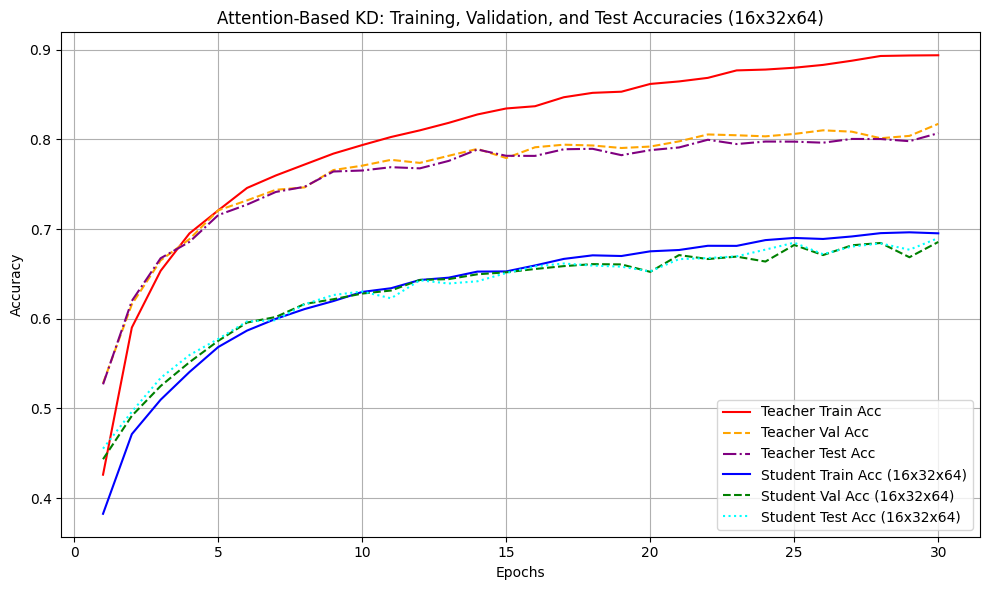

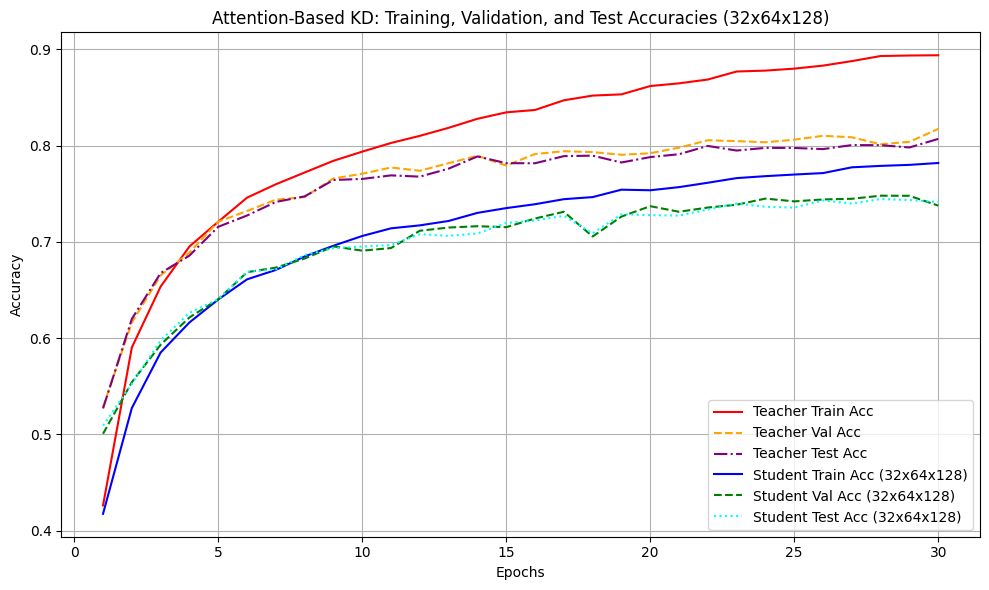

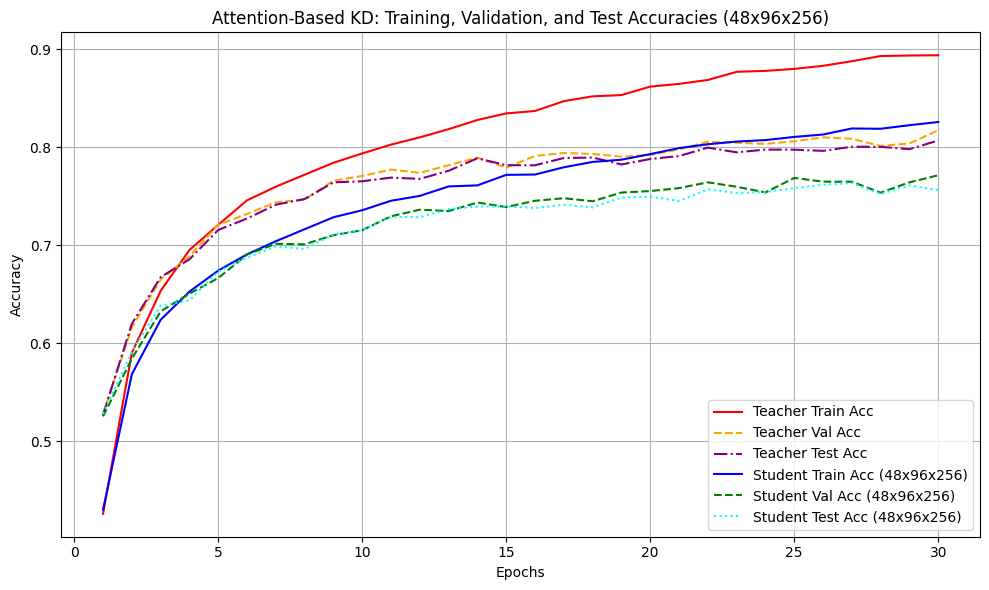

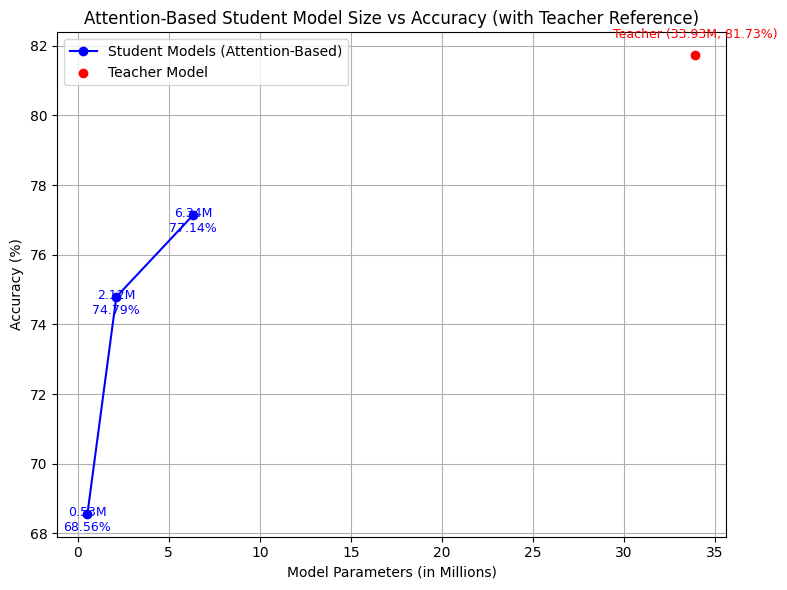

In [ ]:
# Call the Training Function for Attention-Based KD
train_attention_kd_models(
    student_sizes=student_sizes,  # List of student sizes (e.g., [(16, 32, 64), ...])
    teacher=teacher,              # Pre-trained Teacher Model
    train_loader=train_loader,    # Training DataLoader
    val_loader=val_loader,        # Validation DataLoader
    test_loader=test_loader,      # Test DataLoader
    epochs=epochs,                # Number of epochs
    learning_rate=learning_rate,  # Learning rate
    lambda_attention=lambda_attention  # Weight for attention loss
)

# Plot Training, Validation, and Test Accuracies for All Students
plot_attention_kd_results(
    attention_student_results=attention_student_results,  # Dictionary of student results
    train_acc_teacher=train_acc_teacher,                  # Teacher's training accuracy
    val_acc_teacher=val_acc_teacher,                      # Teacher's validation accuracy
    test_acc_teacher=test_acc_teacher,                    # Teacher's test accuracy
    epochs=epochs                                         # Number of epochs
)

# Plot Model Size vs Accuracy for Attention-Based KD
teacher_params_normalized = teacher_params / 1e6  # Normalize teacher model size for plotting
plot_model_size_vs_accuracy(
    attention_student_results=attention_student_results,  # Dictionary of student results
    teacher_params=teacher_params,                        # Teacher model size in parameters
    teacher_accuracy=max(val_acc_teacher) * 100,          # Teacher validation accuracy
    teacher_params_normalized=teacher_params_normalized   # Teacher model size in millions
)


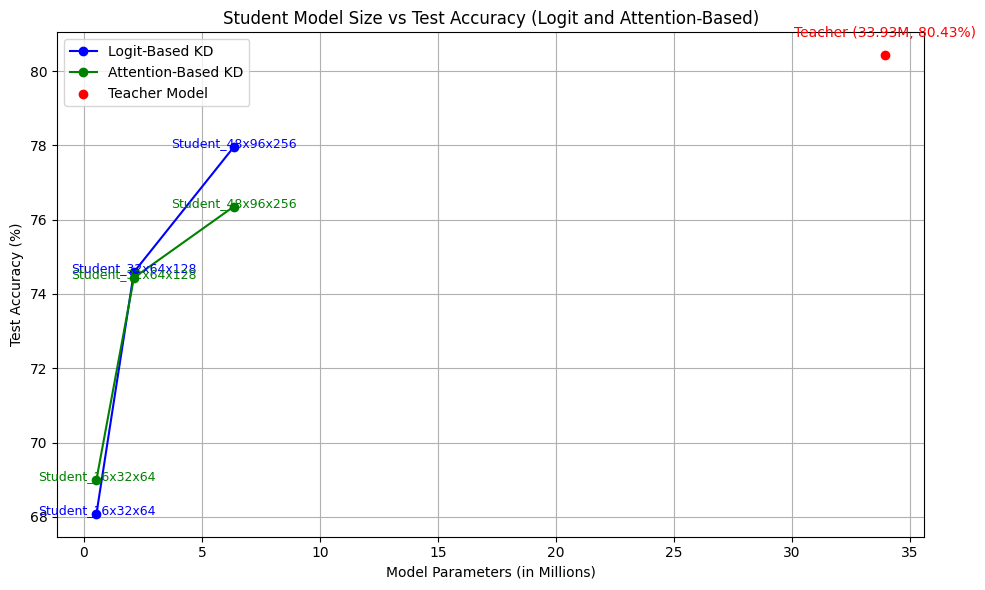

In [62]:
# Prepare data for graphing
distillation_models = [key for key in student_results.keys()]
attention_models = [key for key in attention_student_results.keys()]

# Use test accuracies instead of validation accuracies
distillation_test_accuracies = [results["test_max_acc"] for results in student_results.values()]
attention_test_accuracies = [results["test_max_acc"] for results in attention_student_results.values()]

distillation_params = [results["params"] / 1e6 for results in student_results.values()]  # Normalize params to millions
attention_params = [results["params"] / 1e6 for results in attention_student_results.values()]  # Normalize params to millions

# Plotting
plt.figure(figsize=(10, 6))

# Distillation models
plt.plot(distillation_params, distillation_test_accuracies, 'o-', label="Logit-Based KD ", color="blue")
for i, model in enumerate(distillation_models):
    plt.text(distillation_params[i], distillation_test_accuracies[i], model, fontsize=9, ha="center", color="blue")

# Attention-based models
plt.plot(attention_params, attention_test_accuracies, 'o-', label="Attention-Based KD", color="green")
for i, model in enumerate(attention_models):
    plt.text(attention_params[i], attention_test_accuracies[i], model, fontsize=9, ha="center", color="green")

# Adding teacher model for reference
teacher_params_normalized = teacher_params / 1e6  # Teacher params in millions
plt.scatter([teacher_params_normalized], [teacher_test_accuracy * 100], color='red', label="Teacher Model ", zorder=5)
plt.text(teacher_params_normalized, teacher_test_accuracy * 100 + 0.5,
         f"Teacher ({teacher_params_normalized:.2f}M, {teacher_test_accuracy * 100:.2f}%)",
         fontsize=10, color="red", ha="center")

# Labels and title
plt.xlabel("Model Parameters (in Millions)")
plt.ylabel("Test Accuracy (%)")
plt.title("Student Model Size vs Test Accuracy (Logit and Attention-Based)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#Combined Knowledge Distillation

In [44]:
# newHyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 30
temperature = 5.0
alpha = 0.7
lambda_attention = 0.5  # Weight for attention-based loss in combined KD

# Combined KD Loss Function
def combined_kd_loss(student_outputs, teacher_outputs, labels, student_features, teacher_features, temperature, alpha, lambda_attention):
    # Logit-based distillation loss
    logit_loss = F.kl_div(
        F.log_softmax(student_outputs / temperature, dim=1),
        F.softmax(teacher_outputs / temperature, dim=1),
        reduction="batchmean"
    ) * (temperature ** 2)
    # Cross-entropy loss
    hard_loss = F.cross_entropy(student_outputs, labels)
    # Attention loss
    teacher_attention = F.normalize(teacher_features.pow(2).mean(1).view(teacher_features.size(0), -1))
    student_attention = F.normalize(student_features.pow(2).mean(1).view(student_features.size(0), -1))
    att_loss = F.mse_loss(student_attention, teacher_attention)

    return alpha * logit_loss + (1 - alpha) * hard_loss + lambda_attention * att_loss

# Training and Validation Functions
def train_combined_kd(model, loader, optimizer, teacher_model, criterion, temperature, alpha, lambda_attention):
    model.train()
    total_loss, correct = 0, 0
    total_samples = 0  # Track total samples processed
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        if teacher_model:
            with torch.no_grad():
                teacher_features = teacher_model.convs(images)
                teacher_outputs = teacher_model(images)
            student_features = model.convs(images)
            student_outputs = model(images)
            loss = combined_kd_loss(student_outputs, teacher_outputs, labels, student_features, teacher_features, temperature, alpha, lambda_attention)
        else:
            student_outputs = model(images)
            loss = criterion(student_outputs, labels)

        # Update the correct predictions count for accuracy
        correct += (student_outputs.argmax(dim=1) == labels).sum().item()
        total_samples += labels.size(0)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Return the average loss and accuracy
    return total_loss / len(loader), correct / total_samples

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            total_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate_model_on_test_data(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
    return  correct / total

# CUDA Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Models
teacher = TeacherNet().to(device)
student = StudentNet().to(device)

# Optimizers
teacher_optimizer = optim.Adam(teacher.parameters(), lr=learning_rate)
student_optimizer = optim.Adam(student.parameters(), lr=learning_rate)

# Train Student with Combined KD
teacher.load_state_dict(torch.load("best_teacher_model.pth"))
teacher.eval()
train_acc_student, val_acc_student, test_acc_student = [], [], []
for epoch in range(epochs):
    train_loss, train_acc = train_combined_kd(student, train_loader, student_optimizer, teacher, criterion, temperature, alpha, lambda_attention)
    val_loss, val_acc = validate(student, val_loader, criterion)
    test_acc = evaluate_model_on_test_data(student, test_loader)
    train_acc_student.append(train_acc)
    val_acc_student.append(val_acc)
    test_acc_student.append(test_acc)
    print(f"Epoch {epoch+1}/{epochs}, Student Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
torch.save(student.state_dict(), "student_model_combined_kd.pth")

# Final Test Accuracy
teacher_test_accuracy = evaluate_model_on_test_data(teacher, test_loader)
student_test_accuracy = evaluate_model_on_test_data(student, test_loader)

print(f"Teacher Test Accuracy: {teacher_test_accuracy:.2f}")
print(f"Student Test Accuracy (Combined KD): {student_test_accuracy:.2f}")

# Calculate Model Size and Compression Ratio
def calculate_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

teacher_model_size = calculate_model_size(teacher)
student_model_size = calculate_model_size(student)
compression_ratio = student_model_size / teacher_model_size

print(f"Teacher Model Size: {teacher_model_size:,} parameters")
print(f"Student Model Size (Combined KD): {student_model_size:,} parameters")
print(f"Compression Ratio (Student/Teacher): {compression_ratio:.4f}")


<ipython-input-44-05d6620ca73b>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load("best_teacher_model.pth"))


Epoch 1/30, Student Train Acc: 0.4156, Val Acc: 0.4910, Test Acc: 0.4913
Epoch 2/30, Student Train Acc: 0.5255, Val Acc: 0.5574, Test Acc: 0.5587
Epoch 3/30, Student Train Acc: 0.5888, Val Acc: 0.6162, Test Acc: 0.6169
Epoch 4/30, Student Train Acc: 0.6260, Val Acc: 0.6383, Test Acc: 0.6373
Epoch 5/30, Student Train Acc: 0.6498, Val Acc: 0.6517, Test Acc: 0.6591
Epoch 6/30, Student Train Acc: 0.6713, Val Acc: 0.6632, Test Acc: 0.6694
Epoch 7/30, Student Train Acc: 0.6829, Val Acc: 0.6799, Test Acc: 0.6726
Epoch 8/30, Student Train Acc: 0.6938, Val Acc: 0.6995, Test Acc: 0.6906
Epoch 9/30, Student Train Acc: 0.7016, Val Acc: 0.7046, Test Acc: 0.7065
Epoch 10/30, Student Train Acc: 0.7126, Val Acc: 0.7165, Test Acc: 0.7129
Epoch 11/30, Student Train Acc: 0.7208, Val Acc: 0.7194, Test Acc: 0.7153
Epoch 12/30, Student Train Acc: 0.7268, Val Acc: 0.7231, Test Acc: 0.7084
Epoch 13/30, Student Train Acc: 0.7329, Val Acc: 0.7324, Test Acc: 0.7130
Epoch 14/30, Student Train Acc: 0.7390, Val Acc

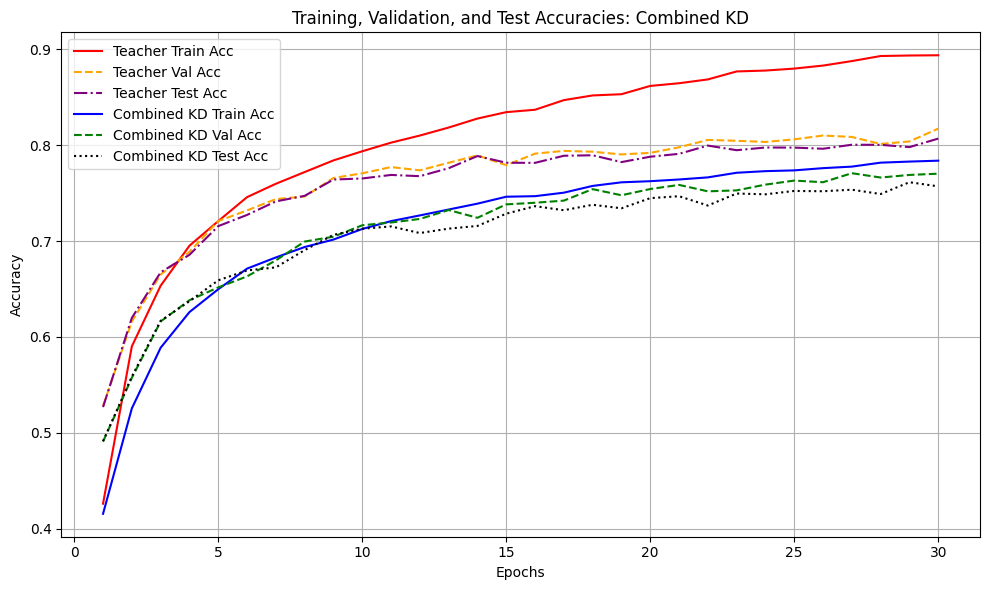

In [64]:
# Plot Training, Validation, and Test Accuracies for Combined KD
plt.figure(figsize=(10, 6))

# Plot Teacher Accuracies
plt.plot(range(1, epochs + 1), train_acc_teacher, label="Teacher Train Acc", color="red", linestyle="-")
plt.plot(range(1, epochs + 1), val_acc_teacher, label="Teacher Val Acc", color="orange", linestyle="--")
plt.plot(range(1, epochs + 1), test_acc_teacher, label="Teacher Test Acc", color="purple", linestyle="-.")

# Plot Combined KD Accuracies
plt.plot(range(1, epochs + 1), train_acc_student, label="Combined KD Train Acc", color="blue", linestyle="-")
plt.plot(range(1, epochs + 1), val_acc_student, label="Combined KD Val Acc", color="green", linestyle="--")
plt.plot(range(1, epochs + 1), test_acc_student, label="Combined KD Test Acc", color="black", linestyle=":")

# Add labels, legend, and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracies: Combined KD")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


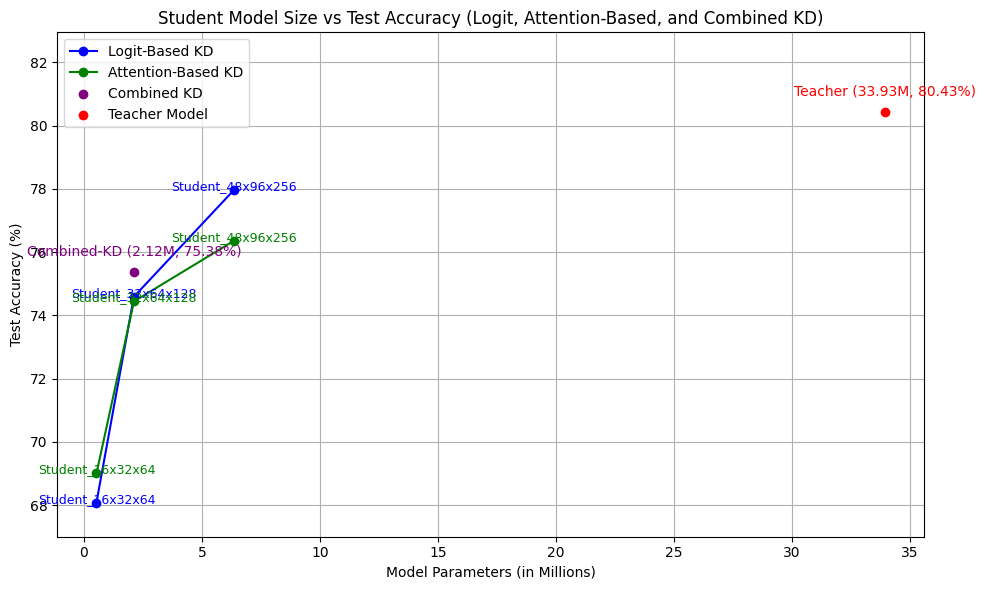

In [63]:
# Prepare data for graphing
distillation_models = [key for key in student_results.keys()]
attention_models = [key for key in attention_student_results.keys()]

# Use test accuracies instead of validation accuracies
distillation_test_accuracies = [results["test_max_acc"] for results in student_results.values()]
attention_test_accuracies = [results["test_max_acc"] for results in attention_student_results.values()]

distillation_params = [results["params"] / 1e6 for results in student_results.values()]  # Normalize params to millions
attention_params = [results["params"] / 1e6 for results in attention_student_results.values()]  # Normalize params to millions

# Combined KD results
combined_kd_params = student_model_size / 1e6  # Combined KD parameters in millions
combined_kd_test_accuracy = student_test_accuracy  # Combined KD test accuracy

# Plotting
plt.figure(figsize=(10, 6))

# Distillation models
plt.plot(distillation_params, distillation_test_accuracies, 'o-', label="Logit-Based KD", color="blue")
for i, model in enumerate(distillation_models):
    plt.text(distillation_params[i], distillation_test_accuracies[i], model, fontsize=9, ha="center", color="blue")

# Attention-based models
plt.plot(attention_params, attention_test_accuracies, 'o-', label="Attention-Based KD", color="green")
for i, model in enumerate(attention_models):
    plt.text(attention_params[i], attention_test_accuracies[i], model, fontsize=9, ha="center", color="green")

# Combined KD model
plt.scatter([combined_kd_params], [combined_kd_test_accuracy * 100], color="purple", label="Combined KD ", zorder=5)
plt.text(combined_kd_params, combined_kd_test_accuracy * 100 + 0.5,
         f"Combined-KD ({combined_kd_params:.2f}M, {combined_kd_test_accuracy * 100:.2f}%)",
         fontsize=10, color="purple", ha="center")

# Adding teacher model for reference
teacher_params_normalized = teacher_model_size / 1e6  # Teacher params in millions
plt.scatter([teacher_params_normalized], [teacher_test_accuracy * 100], color='red', label="Teacher Model ", zorder=5)
plt.text(teacher_params_normalized, teacher_test_accuracy * 100 + 0.5,
         f"Teacher ({teacher_params_normalized:.2f}M, {teacher_test_accuracy * 100:.2f}%)",
         fontsize=10, color="red", ha="center")

# Set y-axis limit to start from 68
plt.ylim(67, max(max(distillation_test_accuracies), max(attention_test_accuracies), combined_kd_test_accuracy * 100) + 5)

# Labels and title
plt.xlabel("Model Parameters (in Millions)")
plt.ylabel("Test Accuracy (%)")
plt.title("Student Model Size vs Test Accuracy (Logit, Attention-Based, and Combined KD)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [58]:
# Add Combined KD results to the existing student and attention-based results
combined_data = {
    "Student Model": (
        [key for key in student_results.keys()] +
        [key for key in attention_student_results.keys()] +
        ["Combined KD"]
    ),
    "Size (Params)": (
        [results["params"] for results in student_results.values()] +
        [results["params"] for results in attention_student_results.values()] +
        [combined_kd_params * 1e6]  # Convert from millions to raw count
    ),
    "Compression Ratio": (
        [results["compression_ratio"] for results in student_results.values()] +
        [results["compression_ratio"] for results in attention_student_results.values()] +
        [combined_kd_params * 1e6 / teacher_model_size]
    ),
    "Validation Accuracy (%)": (
        [results["accuracy"] for results in student_results.values()] +
        [results["accuracy"] for results in attention_student_results.values()] +
        [student_accuracy]
    ),
    "Test Accuracy (%)": (
        [results["test_max_acc"] for results in student_results.values()] +
        [results["test_max_acc"] for results in attention_student_results.values()] +
        [combined_kd_test_accuracy * 100]  # Convert to percentage
    ),
    "Method": (
        ["Logit"] * len(student_results) +
        ["Attention-Based"] * len(attention_student_results) +
        ["Combined KD"]
    )
}

# Create a DataFrame for combined results
combined_df = pd.DataFrame(combined_data)

# Format the table for better readability
combined_df["Size (Params)"] = combined_df["Size (Params)"].apply(lambda x: f"{int(x):,}")
combined_df["Compression Ratio"] = combined_df["Compression Ratio"].apply(lambda x: f"{x:.4f}")
combined_df["Validation Accuracy (%)"] = combined_df["Validation Accuracy (%)"].apply(lambda x: f"{x:.2f}%")
combined_df["Test Accuracy (%)"] = combined_df["Test Accuracy (%)"].apply(lambda x: f"{x:.2f}%")

# Print the table
print(combined_df.to_string(index=False))


    Student Model Size (Params) Compression Ratio Validation Accuracy (%) Test Accuracy (%)          Method
 Student_16x32x64       530,090            0.0156                  68.35%            68.08%           Logit
Student_32x64x128     2,117,962            0.0624                  75.09%            74.59%           Logit
Student_48x96x256     6,337,194            0.1868                  78.54%            77.95%           Logit
 Student_16x32x64       530,090            0.0156                  68.56%            69.00% Attention-Based
Student_32x64x128     2,117,962            0.0624                  74.79%            74.44% Attention-Based
Student_48x96x256     6,337,194            0.1868                  77.14%            76.35% Attention-Based
      Combined KD     2,117,962            0.0624                  78.54%            75.38%     Combined KD
